## Architecture
Body of Text -> Extract Meaning -> Generate Visualization of the Meaning

Body of Text -> Text Chunker -> Summarizer -> Image Finder -> Image Combiner

## Summarizer

Text -> Summarizer -> "Subject Verb Object"

*** (categorizing the chunk) change to "relative proportion of verbs that are in different categories"
ex: 60% action verbs, when the average nearby chunks or across the passage is 40% means it's a movement scene
alternatives:
- dialog
- ideas
- exposition

fade between images for the chunk, positioning/changes between fades is affected by category

1. **Data clean-up**: removing special characters, numeric values, stop words and punctuations.
2. **Tokenization**: creation of tokens (Word tokens and Sentence tokens)
3. **Frequencies**: Calculate the word frequency for each word.
4. **Summarize**: pick the words to use for the summary (do statistics and pick outliers, limit verbs to 2, nouns to 4).

## Image Combiner

Given a set of noun and verb images
1. Stitch verb images together to be as close to square-shaped as possible.
2. Change opacity to gradient 100->0 on noun image edges.
3. Put nouns in corners starting from top-left, clockwise. Shrink them to max 1/2 width of the verb they end up in.
4. Deep dream to further smooth transitions.

Examples:

* https://stackabuse.com/text-summarization-with-nltk-in-python/
* https://medium.com/analytics-vidhya/simple-text-summarization-using-nltk-eedc36ebaaf8
* https://github.com/DivakarPM/NLP/blob/master/Text_Summarization/Text_Summarization.ipynb


In [1]:
import requests
# import bs4 as BeautifulSoup
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import re

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Douglas.Hindson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Douglas.Hindson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Get the whole text body
response = requests.get('https://www.gutenberg.org/files/11/11-0.txt')
text_body = response.text

In [4]:
text_body = text_body.replace('â', '"')
print(text_body[:20000])

ï»¿The Project Gutenberg eBook of Alice"s Adventures in Wonderland, by Lewis Carroll

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: Alice"s Adventures in Wonderland

Author: Lewis Carroll

Release Date: January, 1991 [eBook #11]
[Most recently updated: October 12, 2020]

Language: English

Character set encoding: UTF-8

Produced by: Arthur DiBianca and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK ALICE"S ADVENTURES IN WONDERLAND ***

[Illustration]




Alice"s Adventures in Wonderland

by Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

Contents

 CHAPTER I.     Down the R

In [5]:
chapters = re.split("CHAPTER .*\.\r\n.*\n", text_body)

chapter_1 = chapters[1]
paragraphs = re.split("\r\n\r\n", chapter_1)
p = 0
chunks = []
chunk = []
while p < len(paragraphs):
    chunk.append(paragraphs[p])
    if sum(len(c) for c in chunk) >= 2500:
        chunks.append(chunk)
        chunk = []
    p += 1
if chunk:
    chunks.append(chunk)

print([len(c) for c in chunks])
print([sum(len(c) for c in ch) for ch in chunks])




[8, 4, 5, 9, 7]
[2681, 3035, 2686, 2686, 638]


In [ ]:
# Pick the first chunk
chapter_1_start = "CHAPTER I.\r\nDown the Rabbit-Hole\r\n\r\n\r\n"
chapter_2_start = "CHAPTER II.\r\nThe Pool of Tears\r\n\r\n\r\n"
paragraph_end = "\r\n\r\n"

# first paragraph
chapter_1_paragraph_1 = re.search(f"{chapter_1_start}(?s:.*?){paragraph_end}", text_body)
paragraph_1 = chapter_1_paragraph_1.group(0)[len(chapter_1_start):-len(paragraph_end)]
print(paragraph_1)

# first 2500 words
chapter_1 = re.search(f"{chapter_1_start}(?s:.*)({chapter_2_start}?)", text_body)
chapter_1 = chapter_1.group(0)[len(chapter_1_start):-len(chapter_2_start)]
chunk_1 = chapter_1[:2500]
print(chunk_1)

In [54]:
nltk.download("stopwords")
stop_words = stopwords.words('english')
punctuation = punctuation + '\n' + '\r' + '`'
punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Douglas.Hindson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n\r`'

In [55]:
tokens = word_tokenize(chunk_1)
tokens_pos = nltk.pos_tag(tokens)

def include_word(word):
    if word.lower() in stop_words:
        return False
    if word.lower() in punctuation:
        return False
    if not str.isalpha(word[0]):
        return False
    return True


word_frequencies = {}
for word, pos in tokens_pos:
    if include_word(word):
        if (word, pos[0]) not in word_frequencies.keys():
            # pos[0] condenses parts of speech
            # https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk
            word_frequencies[(word, pos[0])] = 1
        else:
            word_frequencies[(word, pos[0])] += 1

top_frequencies = sorted(word_frequencies.items(), key=lambda a: a[1], reverse=True)
top_frequencies


[(('Alice', 'N'), 7),
 (('pictures', 'N'), 3),
 (('suddenly', 'R'), 3),
 (('Rabbit', 'N'), 3),
 (('time', 'N'), 3),
 (('went', 'V'), 3),
 (('well', 'N'), 3),
 (('get', 'V'), 2),
 (('sister', 'N'), 2),
 (('nothing', 'N'), 2),
 (('book', 'N'), 2),
 (('conversations', 'N'), 2),
 (('thought', 'V'), 2),
 (('considering', 'V'), 2),
 (('mind', 'N'), 2),
 (('ran', 'V'), 2),
 (('think', 'V'), 2),
 (('way', 'N'), 2),
 (('watch', 'N'), 2),
 (('looked', 'V'), 2),
 (('across', 'I'), 2),
 (('never', 'R'), 2),
 (('see', 'V'), 2),
 (('rabbit-hole', 'J'), 2),
 (('moment', 'N'), 2),
 (('like', 'I'), 2),
 (('deep', 'J'), 2),
 (('fell', 'V'), 2),
 (('look', 'V'), 2),
 (('cupboards', 'N'), 2),
 (('jar', 'N'), 2),
 (('one', 'C'), 2),
 (('beginning', 'V'), 1),
 (('tired', 'J'), 1),
 (('sitting', 'V'), 1),
 (('bank', 'N'), 1),
 (('twice', 'V'), 1),
 (('peeped', 'V'), 1),
 (('reading', 'V'), 1),
 (('use', 'N'), 1),
 (('well', 'R'), 1),
 (('could', 'M'), 1),
 (('hot', 'J'), 1),
 (('day', 'N'), 1),
 (('made', 'V

In [56]:
nouns = filter(lambda f: f[0][1] == 'N', top_frequencies)
verbs = filter(lambda f: f[0][1] == 'V', top_frequencies)
subject = next(nouns)[0][0]
verb = next(verbs)[0][0]
object1 = next(nouns)[0][0]
object2 = next(nouns)[0][0]

print(f"{subject} {verb} {object1} {object2}.")

Alice went pictures Rabbit.


In [57]:
import os
GOOGLE_CUSTOM_SEARCH_API_KEY = os.getenv('GOOGLE_CUSTOM_SEARCH_API_KEY')
GOOGLE_SEARCH_ENGINE_ID = os.getenv('GOOGLE_SEARCH_ENGINE_ID')

response = requests.get(
    'https://www.googleapis.com/customsearch/v1',
    params={
        'q': f'{subject}+{verb}+{object1}+{object2}',
        "cx": GOOGLE_SEARCH_ENGINE_ID,
        'key': GOOGLE_CUSTOM_SEARCH_API_KEY,
        'fileType': 'jpg',
        "count": 1,
        "startIndex": 1,
        "inputEncoding": "utf8",
        "outputEncoding": "utf8",
        "safe": "active",
        "searchType": "image",
        "imgSize": "medium",
    }
)
response.json()

{'kind': 'customsearch#search',
 'url': {'type': 'application/json',
  'template': 'https://www.googleapis.com/customsearch/v1?q={searchTerms}&num={count?}&start={startIndex?}&lr={language?}&safe={safe?}&cx={cx?}&sort={sort?}&filter={filter?}&gl={gl?}&cr={cr?}&googlehost={googleHost?}&c2coff={disableCnTwTranslation?}&hq={hq?}&hl={hl?}&siteSearch={siteSearch?}&siteSearchFilter={siteSearchFilter?}&exactTerms={exactTerms?}&excludeTerms={excludeTerms?}&linkSite={linkSite?}&orTerms={orTerms?}&relatedSite={relatedSite?}&dateRestrict={dateRestrict?}&lowRange={lowRange?}&highRange={highRange?}&searchType={searchType}&fileType={fileType?}&rights={rights?}&imgSize={imgSize?}&imgType={imgType?}&imgColorType={imgColorType?}&imgDominantColor={imgDominantColor?}&alt=json'},
 'queries': {'request': [{'title': 'Google Custom Search - Alice+went+pictures+Rabbit',
    'totalResults': '171000000',
    'searchTerms': 'Alice+went+pictures+Rabbit',
    'count': 10,
    'startIndex': 1,
    'inputEncoding': 

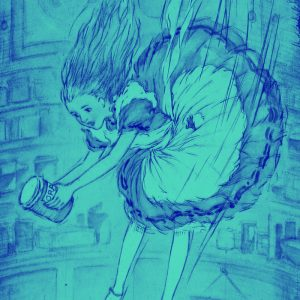

In [58]:
from IPython.display import Image as ImageDisplay
from IPython.display import display

image_url = response.json()['items'][0]['link']
img_data = requests.get(image_url).content
filename = 'images/chunk_1.jpg'
with open(filename, 'wb') as handler:
    handler.write(img_data)

display(ImageDisplay(filename=filename))

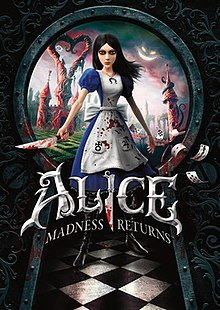

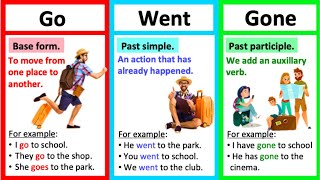

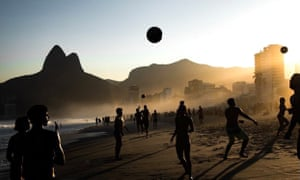

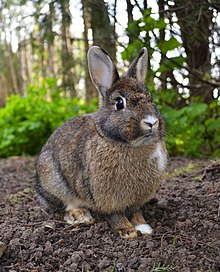

In [60]:
ImageFilename = str
def download_image_for_url(url: str, filename: ImageFilename) -> None:
    image_response = requests.get(url, headers={'User-Agent': 'Text Visualizer/0.1 (github.com/curiousest) requests/2.27.1'})
    image_response.raise_for_status()
    img_data = image_response.content
    with open(filename, 'wb') as handler:
        handler.write(img_data)

def download_image_for_text(text: str) -> ImageFilename:
    response = requests.get(
        'https://www.googleapis.com/customsearch/v1',
        params={
            'q': text,
            "cx": GOOGLE_SEARCH_ENGINE_ID,
            'key': GOOGLE_CUSTOM_SEARCH_API_KEY,
            'fileType': 'jpg',
            "count": 2,
            "startIndex": 1,
            "inputEncoding": "utf8",
            "outputEncoding": "utf8",
            "safe": "active",
            "searchType": "image",
            "imgSize": "medium",
        }
    )
    response.raise_for_status()
    results = response.json()
    if len(results['items']) == 0:
        raise FileNotFoundError
    filename = f'images/{results["items"][0]["title"]}.jpg'
    try:
        download_image_for_url(results["items"][0]["link"], filename)
    except requests.exceptions.HTTPError:
        filename = f'images/{results["items"][1]["title"]}.jpg'
        download_image_for_url(results["items"][0]["link"], filename)
    return filename

filenames = []
for image_text in [subject, verb, object1, object2]:
    filename = download_image_for_text(image_text)
    display(ImageDisplay(filename=filename))
    filenames.append(filename)

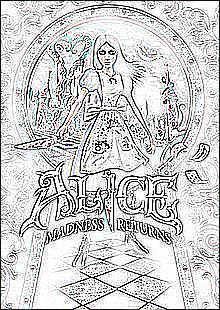

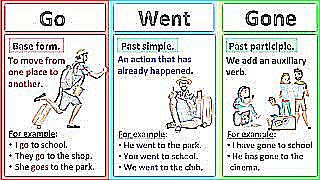

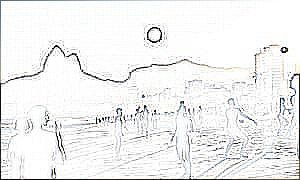

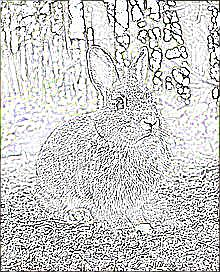

In [65]:

# 1. Stitch verb images together to be as close to square-shaped as possible.
# Nouns use edges?
# 2. Change opacity to gradient 100->0 on noun image edges.
# 3. Put nouns in corners starting from top-left, clockwise. Shrink them to max 1/2 width of the verb they end up in.
# 4. Deep dream to further smooth transitions.

from PIL import Image
from PIL.ImageFilter import (
   BLUR, CONTOUR, DETAIL, EDGE_ENHANCE, EDGE_ENHANCE_MORE,
   EMBOSS, FIND_EDGES, SMOOTH, SMOOTH_MORE, SHARPEN
)
import numpy as np


for filename in filenames:
    img = Image.open(filename)
    img = img.filter(CONTOUR)
    imgnp = np.array(img)

    # https://stackoverflow.com/questions/765736/how-to-use-pil-to-make-all-white-pixels-transparent
    white = np.sum(imgnp[:,:,:0], axis=2)
    white_mask = np.where(white == 255*3, 1, 0)
    alpha = np.where(white_mask, 0, imgnp[:,:,-1])
    imgnp[:,:,-1] = alpha

    img = Image.fromarray(np.uint8(imgnp))
    contour_filename = filename.replace('.jpg', '_contour.jpg')
    img.save(contour_filename)
    display(ImageDisplay(filename=contour_filename))

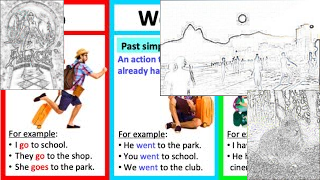

In [82]:
from typing import Callable

TopLeft = lambda fg, bg: (0, 0)
TopRight = lambda fg, bg: (bg.size[0] - fg.size[0], 0)
BottomRight = lambda fg, bg: (bg.size[0] - fg.size[0], bg.size[1] - fg.size[1])
BottomLeft = lambda fg, bg: (0, bg.size[1] - fg.size[1])

def apply_foreground(foreground: Image, background: Image, location: Callable) -> Image:
    if foreground.size[0] > foreground.size[1]:
        new_width = min(background.size[0] // 2, foreground.size[0])
        new_height = round(foreground.size[1] * (new_width / foreground.size[0]))
    else:
        new_height = min(background.size[1] // 2, foreground.size[1])
        new_width = round(foreground.size[0] * (new_height / foreground.size[1]))
    foreground = foreground.resize((new_width, new_height))
    foreground = foreground.convert('RGBA')
    background = background.convert('RGBA')
    background.paste(
        foreground,
        location(foreground, background),
        foreground,
    )
    return background

verb = Image.open(filenames[1])
subject = Image.open(filenames[0].replace('.jpg', '_contour.jpg'))
object1 = Image.open(filenames[2].replace('.jpg', '_contour.jpg'))
object2 = Image.open(filenames[3].replace('.jpg', '_contour.jpg'))

result = apply_foreground(subject, verb, TopLeft)
result = apply_foreground(object1, result, TopRight)
result = apply_foreground(object2, result, BottomRight)
display(result)